<center>
    <h1>Qubot: Designing a Bot to Perform Autonomous Black Box Testing</h1>
    <br>
    Anthony  Krivonos<br>
    ak4483@columbia.edu<br>
    COMS  E6156  Topics  in  Software  Engineering
    <br><br>
    <h3>Accompanying Experiments</h3>
</center>

> **Goal:** In this paper, we will be examining several approaches towards building an automated test suite called Qubot that performs exploratory black box tests autonomously. Whereas traditional automated test suites require developers to painstakingly write test functions and scripts that mimic user interaction with the software under test (SUT), we will attempt to design Qubot such that there is minimal setup and configuration required for the developer to perform exploratory tests.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Experiment 1

## Portability and Feasibility:  Deciding on a Robust Automated Testing Architecture

### Portability Test

How many minutes does it take to set up an arbitrary test?

#### Stassy # Steps to Set Up

In [2]:
# Note: Stassy setup steps were not provided, but rather inferred
#       from reading the respective paper.
stassy_set_up_steps = {
    "Tester defines all pages in SUT": 60,
    "Tester defines all functions in SUT": 60,
    "Tester writes manual test cases": 120,
    "Stassy generates reports after tests conclude": 1,
}

# Count estimated number of setup steps
stassy_set_up_steps_count = sum(stassy_set_up_steps.values())

stassy_set_up_steps_count

242

#### SAT # Steps to Set Up

In [6]:
# Note: SAT setup steps taken loosely from flowchart in Figure 2
#       and may be wildly inaccurate.
sat_set_up_steps = {
    "Tester defines URL to test": 1,
    "SAT crawls the webpage at the given URL": 10,
    "TCS sheet is automatically generated": 5,
    "Tester examines TCS sheet for errors and adds test cases": 30,
    "Tester runs the test cases from the TCS sheet": 5,
}

# Count estimated number of setup steps
sat_set_up_steps_count = sum(sat_set_up_steps.values())

sat_set_up_steps_count

51

#### AppFlow # Steps to Set Up

In [10]:
# Note: AppFlow setup steps taken from "5. APPLYING A TEST LIBRARY TO A NEW
#       APP" section of the paper.
appflow_set_up_steps = {
    "Tester takes screenshots of SUT": 5,
    "AppFlow automatically labels widgets and screens": 10,
    "Tester uses GUI utility to relabel classification errors": 20,
    "Tester writes test cases in AppFlow language": 60,
    "AppFlow runs tests": 5,
}

# Count estimated number of setup steps
appflow_set_up_steps_count = sum(appflow_set_up_steps.values())

appflow_set_up_steps_count

96

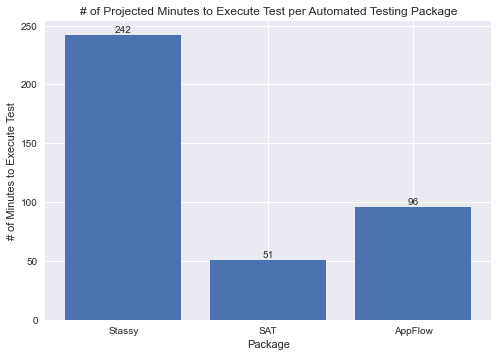

In [12]:
packages = ['Stassy', 'SAT', 'AppFlow']
set_up_steps = [stassy_set_up_steps_count, sat_set_up_steps_count, appflow_set_up_steps_count]

bars = [i for i, _ in enumerate(packages)]

plt.bar(bars, set_up_steps)
plt.xlabel("Package")
plt.ylabel("# of Minutes to Execute Test")
plt.title("# of Projected Minutes to Execute Test per Automated Testing Package")

plt.xticks(bars, packages)

# Label bars
for i in range(len(set_up_steps)):
    plt.annotate(str(set_up_steps[i]), xy=(i, set_up_steps[i]), ha='center', va='bottom')

plt.show()

### Feasibility Test

How many code files are present in each framework?

#### Stassy # of Files to Code

In [14]:
# Note: Stassy codebase was not provided, so estimates were made from the
#       description of the architecture from the paper
stassy_arch_file_counts = {
    "custom_exception_package": 1, # one custom exception
    "main_package": 1, # one XML script evaluator
    "object_repository_package": 114, # assume 1 file per DOM element; see list here: https://eastmanreference.com/complete-list-of-html-tags
    "reusable_functions_package": 1, # estimation; assume most functions in object_repository_package are unique
    "test_specs_package": 0, # unknown and up to the implementer
    "utilities_package": 1, # assume all utility functions are all in one folder
    "reports_package": 1, # assume one file to generate reports
    "library_compressed_logic": 0, # contains all jar files; no LOC
}

# Count estimated number of files in Stassy architecture
files_in_stassy_arch = np.sum([stassy_arch_file_counts[c] for c in stassy_arch_file_counts])

files_in_stassy_arch

119

#### SAT # of Files to Code

In [15]:
# Note: SAT codebase was not provided, so estimates were made from the actions in
#       the flow chart in Figure 2 of the paper, as well as the author's software
#       engineering experience.
sat_arch_file_counts = {
    "selenium_connectivity_package": 1, # one file to call Selenium functions from
    "json_data_recording_package": 1, # one file that transcripts HTML contents to JSON for SUT input
    "tcs_generator": 1, # one file to generate TCS sheet and a LOC per row in Test Case Steps (TCS) sheet
    "tcs_runner": 1, # one file to run generated test scripts
    "utilities_package": 1, # assume all utility functions are all in one folder
}

# Count estimated number of files in SAT architecture
files_in_sat_arch = np.sum([sat_arch_file_counts[c] for c in sat_arch_file_counts])

files_in_sat_arch

5

#### AppFlow # of Files to Code

In [16]:
# AppFlow codebase: https://github.com/columbia/appflow
appflow_arch_file_counts = {
    "src_package": 98, # 98 source files in src as of 10 Feb 2021
}

# Count estimated number of files in AppFlow architecture
files_in_appflow_arch = np.sum([appflow_arch_file_counts[c] for c in appflow_arch_file_counts])

files_in_appflow_arch

98

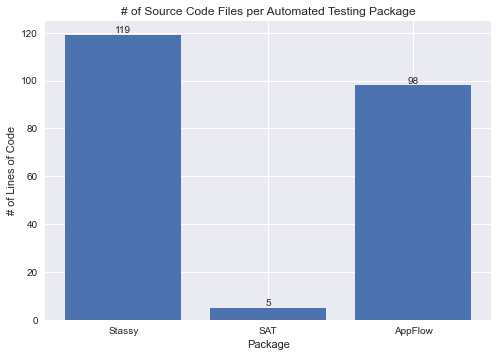

In [9]:
packages = ['Stassy', 'SAT', 'AppFlow']
file_counts = [files_in_stassy_arch, files_in_sat_arch, files_in_appflow_arch]

bars = [i for i, _ in enumerate(packages)]

plt.bar(bars, file_counts)
plt.xlabel("Package")
plt.ylabel("# of Lines of Code")
plt.title("# of Source Code Files per Automated Testing Package")

plt.xticks(bars, packages)

# Label bars
for i in range(len(file_counts)):
    plt.annotate(str(file_counts[i]), xy=(i, file_counts[i]), ha='center', va='bottom')

plt.show()

# Experiment 2

## Intelligence:  Making Qubot Think for Itself

In [10]:
from qubot.ui import UIAction, UITreeNode
from qubot.environment import QLearningEnvironment
from qubot.driver import Driver

### Constructing a UITree for the Testing Environment

The Q-learning technique from both Fastbot and DRIFT will be tested by attempting to navigate from the root of `https://upmed-starmen.web.app/` to the "Log in as a Healthcare Provider" button on `https://upmed-starmen.web.app/signin`.

In [11]:
test_website = "https://upmed-starmen.web.app/"

In [12]:
driver = Driver()
tree = driver.construct_tree(test_website)

In [13]:
tree.set_terminal_node(html_class="SignIn_login_hcp__qYuvP")
tree.print()

NAVIGATE: <html id="" class=""> (a6811b53-d208-4c4f-8a1a-d8f987c25ee7)
	NAVIGATE: <head id="" class=""> (35e844f9-bd0f-c542-878a-8ca0c6c8f0b1)
		NAVIGATE: <meta id="" class=""> (0cde5fe3-bc40-6e48-a809-9b3a6c9b8ec8)
		NAVIGATE: <link id="" class=""> (ae2d3930-40f6-8d46-a90d-c8d5a3d825f3)
		NAVIGATE: <meta id="" class=""> (840c27b5-05c4-af4a-9c84-73addad66796)
		NAVIGATE: <meta id="" class=""> (f0112478-6974-bd48-9f59-1fd7f02e8b4f)
		NAVIGATE: <meta id="" class=""> (0089ed7c-9976-4849-8d25-e8900946ab86)
		NAVIGATE: <link id="" class=""> (8b1d132d-c009-c34b-845f-c94c5693ab8c)
		NAVIGATE: <link id="" class=""> (d1cd76d5-518e-ba4c-8c79-ba7cbeba6d3c)
		NAVIGATE: <title id="" class=""> (d538050b-e762-fd4c-8636-9c09cc59194d)
		NAVIGATE: <script id="" class=""> (9b4bb621-4653-e144-8f22-93a25f474de5)
		NAVIGATE: <script id="" class=""> (894c9d44-69eb-b04d-97ed-65cb6605cc0e)
		NAVIGATE: <script id="" class=""> (d298b3ef-4219-8645-8a42-32ffdf01ec80)
		NAVIGATE: <script id="" class=""> (2f9e4d24-8

### Training the Q-Learning Agent

We will train the Q-learning agent to find the "Log in as a Healthcare Provider" button on `https://upmed-starmen.web.app/signin`.

In [84]:
def reward_func(action: UIAction, node: UITreeNode):
    if node.is_terminal():
        return 100
    elif not node.get_children():
        return 0
    elif action == UIAction.LEFT_CLICK:
        return 5
    return 0

In [85]:
# Constants
alpha = 0.1     # higher alpha   ==> consider more recent information (learning rate)
gamma = 0.01    # higher gamma   ==> long term rewards
epsilon = 0.1     # higher epsilon ==> favor exploitation
decay = 0.01    # higher decay   ==> epsilon decreases faster (more randomness)

train_episodes = 100
test_episodes = 100
max_steps = 1000

In [86]:
env = QLearningEnvironment(tree, reward_func, alpha, gamma, epsilon, decay, max_steps)
env.reset()

In [87]:
env.train(train_episodes)

Training on 100 episodes...
Training done.


In [88]:
env.render()

Q-learning agent
Steps:                  97098
Alpha:                 0.1000
Gamma:                 0.0100
Original epsilon:      0.1000
Current epsilon:       0.3779
Decay:                 0.0100
Training rewards:       13280
Training score:        132.8000
Testing rewards:            0
Testing score:         0.0000
Testing penalties:          0
Testing penalty rate:  0.0000


### Testing the Q-Learning Agent

We will see how adept the Q-learning agent is at finding the image of black sand next to the sign-in options on `https://upmed-starmen.web.app/signin`.

In [89]:
tree.unset_terminal_node(html_class="SignIn_login_hcp__qYuvP")
tree.set_terminal_node(html_class="SignIn_tile_img__1VCWa")
env.test(test_episodes)

Testing on 100 episodes...
Testing done.


In [90]:
env.render()

Q-learning agent
Steps:                  190928
Alpha:                 0.1000
Gamma:                 0.0100
Original epsilon:      0.1000
Current epsilon:       0.3779
Decay:                 0.0100
Training rewards:       13280
Training score:        132.8000
Testing rewards:        54180
Testing score:         541.8000
Testing penalties:          0
Testing penalty rate:  0.0000


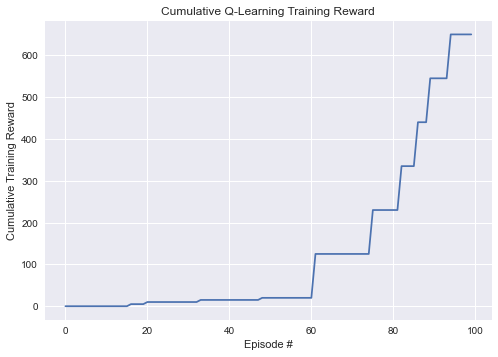

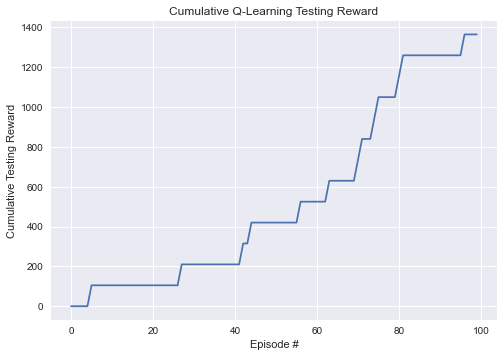

In [95]:
x = range(len(env.get_training_rewards_history()))

plt.plot(x, env.get_training_rewards_history())
plt.xlabel('Episode #')
plt.ylabel('Cumulative Training Reward')
plt.title('Cumulative Q-Learning Training Reward') 
plt.show()

plt.plot(x, env.get_testing_rewards_history())
plt.xlabel('Episode #')
plt.ylabel('Cumulative Testing Reward')
plt.title('Cumulative Q-Learning Testing Reward') 
plt.show()